In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def get_frames(videofile, verbose = False):
    def decode_fourcc(v):
        v = int(v)
        return "".join([chr((v >> 8 * i) & 0xFF) for i in range(4)])

    cap = cv2.VideoCapture(videofile)
    frames = []
    while True:
        # ret is boolean and equals True iff current frame was read successfully
        # frame is numpy.ndarray
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frames.append(frame)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    codec = int(cap.get(cv2.CAP_PROP_FOURCC))
    if verbose:
        print('Number of frames:', len(frames))
        print('Frame size: {} x {}'.format(w, h))    # frame.shape == (n, m)
        print('Frame rate:', fps)
        print('Codec:', decode_fourcc(codec))
    cap.release()
    return frames, {'shape': (w,h), 'fps': fps, 'codec': codec}


def show_frame(frame):
    plt.imshow(frame, cmap='gray')
    plt.show()


def play_video(videofile):
    cap = cv2.VideoCapture(videofile)
    m = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    n = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cv2.namedWindow('video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('video', m//2, n//2)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        cv2.imshow('video', gray_frame)
        # 100 ~ timeout between consecutive frames
        # q is the keyboard button used to close the window
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


def make_video(frames, filename, desc):
    video = cv2.VideoWriter(filename, -1, desc['fps'], desc['shape'])
    for x in frames:
        video.write(x)
    video.release()

Number of frames: 66
Frame size: 1920 x 1080
Frame rate: 30
Codec: avc1


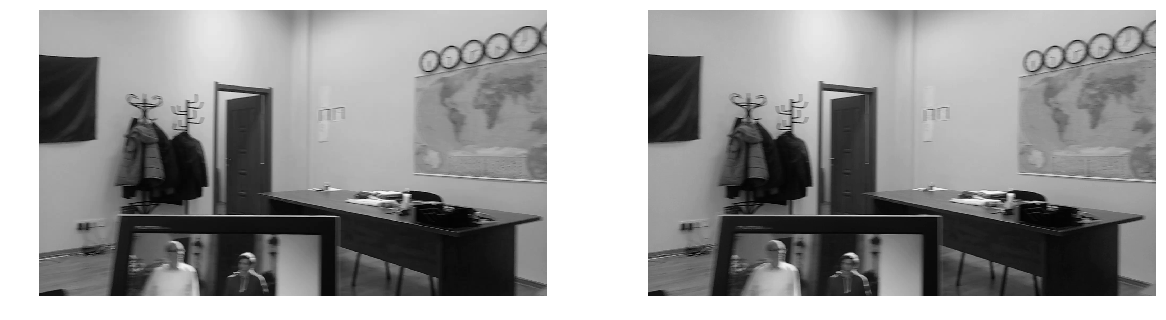

In [4]:
videofile = 'V80420-163103.mp4'
frames, desc = get_frames(videofile, verbose = True);
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(frames[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(frames[1], cmap='gray')
ax[1].axis('off')
plt.show()

In [5]:
%%HTML
<video width="480" height="270" controls>
  <source src="V80420-163103.mp4" type="video/mp4">
</video>

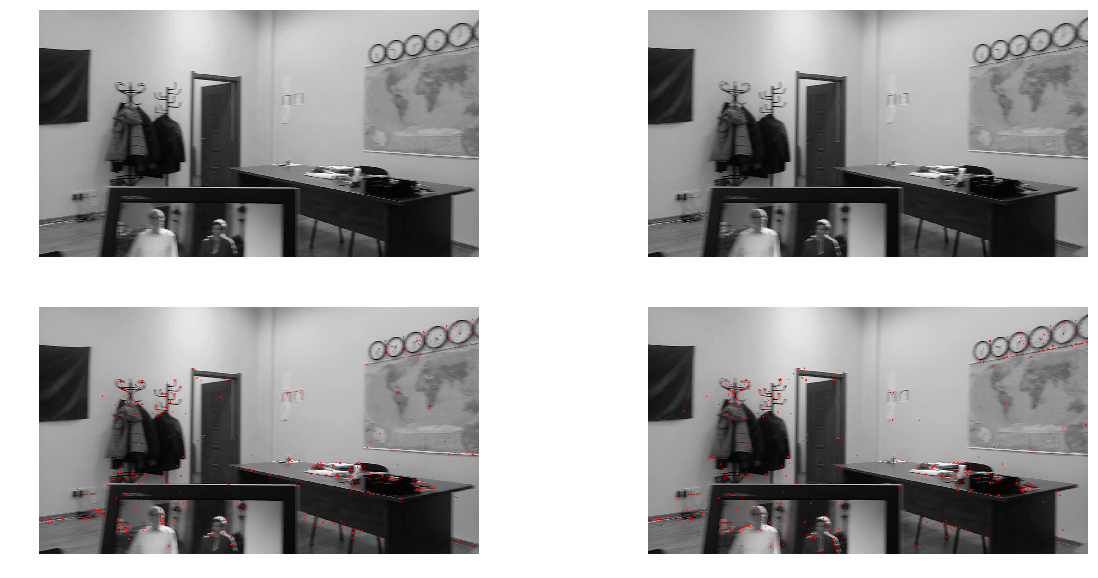

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

f0 = frames[0]
kp0, des0 = sift.detectAndCompute(f0, None)
f0_kp = cv2.drawKeypoints(f0, kp0, None, color=(255,0,0))
cv2.imwrite('f0_kp.png', f0_kp)

f1 = frames[1]
kp1, des1 = sift.detectAndCompute(f1, None)
f1_kp = cv2.drawKeypoints(f1, kp1, None, color=(255,0,0))
cv2.imwrite('f1_kp.png', f1_kp)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax[0][0].imshow(f0, cmap='gray')
ax[0][0].axis('off')
ax[0][1].imshow(f1, cmap='gray')
ax[0][1].axis('off')
ax[1][0].imshow(f0_kp)
ax[1][0].axis('off')
ax[1][1].imshow(f1_kp)
ax[1][1].axis('off')
plt.show()

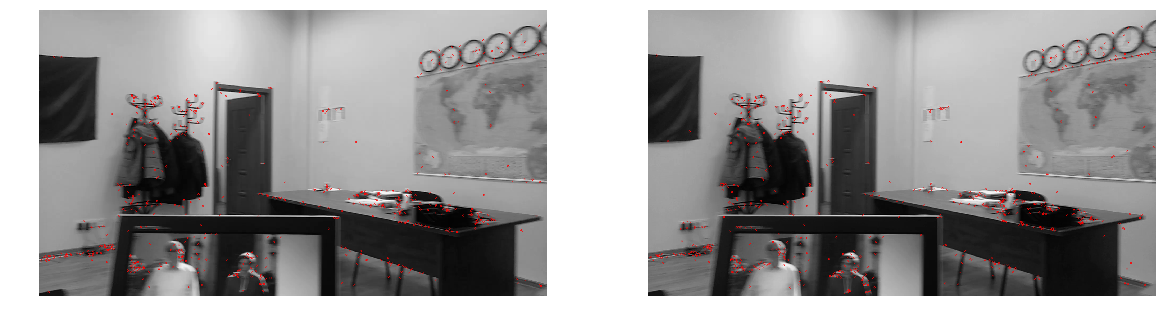

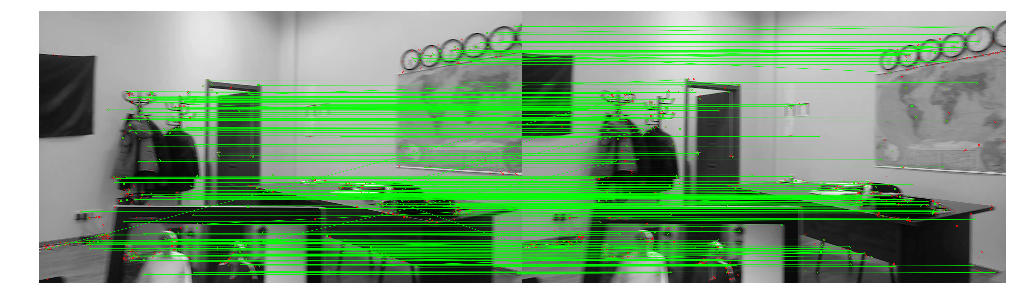

In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)   
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k = 2)
matchesMask = [[0,0] for i in range(len(matches))]
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i] = [1,0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(f0_kp)
ax[0].axis('off')
ax[1].imshow(f1_kp)
ax[1].axis('off')
plt.show()

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv2.drawMatchesKnn(f0, kp0, f1, kp1, matches, None, **draw_params)
plt.figure(figsize=(20, 5))
plt.imshow(img3)
plt.axis('off')
plt.show()

[[ 1.01592718e+00  5.29230860e-06 -2.43784383e+01]
 [ 4.10485104e-03  1.01003067e+00 -5.99600281e+00]
 [ 8.39329769e-06  6.01512134e-07  1.00000000e+00]]


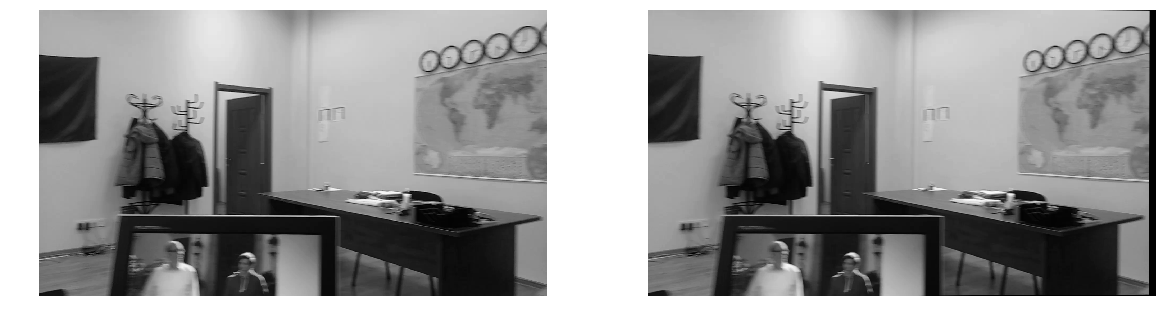

In [11]:
# Docs: https://docs.opencv.org/3.1.0/d1/de0/tutorial_py_feature_homography.html
good_matches = []
for x, y in matches:
    if x.distance < 0.7*y.distance:
        good_matches.append(x)
src_pts = np.float32([kp0[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
dst_pts = np.float32([kp1[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS, 5.0)
print(M)
matchesMask = mask.ravel().tolist()
h, w = f0.shape
pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
#dst = cv2.perspectiveTransform(pts, M)
#M = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
(m, n) = f0.shape
dst = cv2.warpPerspective(f0, M, (n, m))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(f0, cmap='gray')
ax[0].axis('off')
ax[1].imshow(dst, cmap='gray')
ax[1].axis('off')
plt.show()